<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "title"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Improving Facial Emotion Detection with Deep Learning
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#title">¶</a>
    </h1>
</div>

<img src="https://acart.com/wp-content/uploads/2017/04/faceplus-example.png" alt="Facial Recognition And Emotion Detection Model" style="width:100%;height:400px;">

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "import-libraries"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Import Standard Libraries
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#import-libraries">¶</a>
    </h1>
</div>

<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Import Standard Libraries
    </h2>
</div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
# Read all files from folders
import os, sys, time, warnings, sklearn
# ROOT='/kaggle/input'
ROOT='data'
# for dirname, _, filenames in os.walk(ROOT):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [89]:
# Specify important directories
# TRAIN_PATH=ROOT+'/emotion-detection-fer/train'
# TEST_PATH=ROOT+'/emotion-detection-fer/test'
TRAIN_PATH=ROOT+'/fer-2013-images/train'
TEST_PATH=ROOT+'/fer-2013-images/test'
train_angry_img_path=TRAIN_PATH +'/angry'

OVERSAMPLED_TRAIN_PATH=ROOT+'/fed_oversampled/train'
MODEL_PATH='models'
IMAGE_PATH='images'

# Model Architecture path
def model_arch(model_name):
    # !mkdir -p images
    !mkdir images
    arch=IMAGE_PATH+'/fer-2013_'+model_name+'.png'
    return arch

#  TensorFlow Checkpoint save_weight uses .ckpt extension format
def checkpoint_path(model_name):
    # !mkdir models
    checkpoint_path = MODEL_PATH+"/fedav_best_model-"+model_name+".ckpt"
    return checkpoint_path
    


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "exploratory-da"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Exploratory Data Analysis
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#exploratory-da">¶</a>
    </h1>
</div>

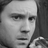

In [4]:
# Load a sample image 
# using open() to open images
image_data = Image.open(train_angry_img_path+'/im0.png')
image_data

Image shape: (48, 48)
Image data array: [[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]
Image array shape: (48, 48)


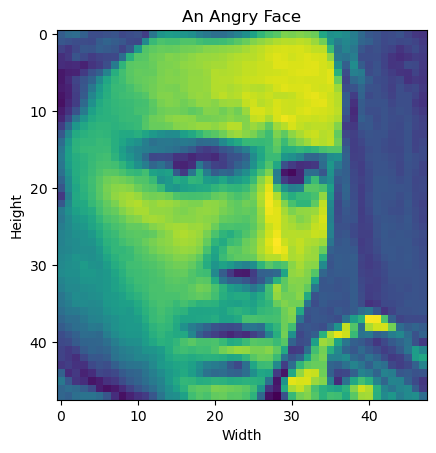

In [5]:
# Get the shape of the image
image=plt.imread(train_angry_img_path+'/im0.png')
print(f'Image shape: {image.shape}')

# Convert image data (like jpeg) to numpy using asarray()
image_array = npy.asarray(image_data)
print(f'Image data array: {image_array}')

# Get the shape of the image array
print(f'Image array shape: {image_array.shape}')

# Printing the image 
plt.imshow(image_array)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('An Angry Face')
plt.show()

In [6]:
# Get the list of folders in the directory as classes
classes=os.listdir(TRAIN_PATH+'/')
classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

 For Statistical Analysis, we'll load the images, convert them to numpy arrays, and store them in a pandas dataframe with the columns 'filename', 'image', and 'label'

In [7]:
# set up file paths and labels
folder_names = classes
label_dict = {folder_names[i]:i for i in range(len(folder_names))}
image_filenames = []
labels = []

# iterate through each folder and collect filenames and labels
for folder_name in folder_names:
    folder_path = os.path.join(TRAIN_PATH, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_filenames.append(os.path.join(folder_name, filename))
            labels.append(label_dict[folder_name])

# create pandas dataframe
df = pds.DataFrame({'filename': image_filenames, 'emotion': labels})

# add 'image' column to dataframe
image_array_list = []
for filename in df['filename']:
    img_path = os.path.join(TRAIN_PATH, filename)
    img = Image.open(img_path)
    img_array = npy.array(img).flatten()
    image_array_list.append(img_array)
df['image'] = image_array_list

dfcopy = df.copy()

# strip and replace commas in 'image' column
# df['image'] = df['image'].apply(lambda x: x.strip('[]').replace(',', ' '))

# convert the image column to a string with comma-separated values
df['image'] = df['image'].apply(lambda x: ' '.join(map(str, x.tolist())))

# remove square brackets from the string representation of the array
df['image'] = df['image'].str.replace('[', '').str.replace(']', '')


# Export the preprocessed file to CSV
!mkdir output
df.to_csv('output/fer-2013-images_preprocessed.csv', index=False)

# display dataframe
cm = sns.light_palette("green", as_cmap=True)
df.tail(10).style.background_gradient(cmap=cm, text_color_threshold = 0.1).format(precision=2).highlight_null('red').set_properties(**{'background-color': '#256d7c;', 'color': 'white'}, subset=['filename'])
df

C:\Users\cmanj\AppData\Local\Temp\ipykernel_8444\4065494635.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['image'] = df['image'].str.replace('[', '').str.replace(']', '')
A subdirectory or file output already exists.


,filename,emotion,image
0,angry\im0.png,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,angry\im1.png,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,angry\im10.png,0,117 116 113 99 78 53 37 34 33 32 31 28 27 30 2...
3,angry\im100.png,0,159 159 145 159 167 161 166 161 170 188 179 16...
4,angry\im1000.png,0,254 254 254 252 235 186 149 156 79 45 33 34 24...
...,...,...,...
28704,surprised\im995.png,6,189 160 144 139 134 135 104 49 47 33 26 20 15 ...
28705,surprised\im996.png,6,145 182 212 139 20 14 12 13 39 44 37 53 104 14...
28706,surprised\im997.png,6,10 16 19 20 20 15 19 33 80 87 111 138 137 142 ...
28707,surprised\im998.png,6,141 148 156 163 171 175 179 184 186 188 191 19...


In [ ]:
df.emotion.value_counts().unique()

array([7215, 4965, 4830, 4097, 3995, 3171,  436], dtype=int64)

In [9]:
dfcopy

,filename,emotion,image
0,angry\im0.png,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,angry\im1.png,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,angry\im10.png,0,"[117, 116, 113, 99, 78, 53, 37, 34, 33, 32, 31..."
3,angry\im100.png,0,"[159, 159, 145, 159, 167, 161, 166, 161, 170, ..."
4,angry\im1000.png,0,"[254, 254, 254, 252, 235, 186, 149, 156, 79, 4..."
...,...,...,...
28704,surprised\im995.png,6,"[189, 160, 144, 139, 134, 135, 104, 49, 47, 33..."
28705,surprised\im996.png,6,"[145, 182, 212, 139, 20, 14, 12, 13, 39, 44, 3..."
28706,surprised\im997.png,6,"[10, 16, 19, 20, 20, 15, 19, 33, 80, 87, 111, ..."
28707,surprised\im998.png,6,"[141, 148, 156, 163, 171, 175, 179, 184, 186, ..."


In [10]:
# dfcopy = df.copy()
dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28709 non-null  object
 1   emotion   28709 non-null  int64 
 2   image     28709 non-null  object
dtypes: int64(1), object(2)
memory usage: 673.0+ KB


In [12]:
# Computing the mean and standard deviation of the pixel values in each image
mean_values = [npy.mean(img) for img in dfcopy['image']]
std_values = [npy.std(img) for img in dfcopy['image']]

# add new columns for mean and standard deviation
dfcopy['pixel_mean'] = mean_values
dfcopy['pixel_std'] = std_values

dfcopy= dfcopy[['filename', 'image', 'pixel_mean', 'pixel_std', 'emotion']]
# print statistical summary
dfcopy.tail(10).style.background_gradient(cmap=cm, text_color_threshold = 0.1).format(precision=2).highlight_null('red').set_properties(**{'background-color': '#256d7c;', 'color': 'white'}, subset=['filename', 'image'])

,filename,image,pixel_mean,pixel_std,emotion
28699,surprised\im990.png,[119 127 152 ... 14 14 14],151.62,90.67,6
28700,surprised\im991.png,[ 0 0 0 ... 189 187 179],113.18,86.09,6
28701,surprised\im992.png,[37 41 35 ... 68 93 80],141.52,73.75,6
28702,surprised\im993.png,[163 163 162 ... 56 54 55],132.54,53.94,6
28703,surprised\im994.png,[190 184 191 ... 1 1 1],117.12,66.27,6
28704,surprised\im995.png,[189 160 144 ... 192 191 191],134.55,66.59,6
28705,surprised\im996.png,[145 182 212 ... 112 88 131],157.80,72.38,6
28706,surprised\im997.png,[ 10 16 19 ... 174 159 147],144.76,65.98,6
28707,surprised\im998.png,[141 148 156 ... 221 218 218],177.85,58.98,6
28708,surprised\im999.png,[120 120 124 ... 185 180 183],171.89,36.00,6


In [13]:
dfcopy.describe().style.background_gradient(cmap=cm, text_color_threshold = 0.1).format(precision=2).highlight_null('red').set_properties(**{'background-color': '#256d7c;', 'color': 'white'}, subset=['emotion'])


,pixel_mean,pixel_std,emotion
count,28709.00,28709.00,28709.00
mean,129.47,54.03,3.25
std,33.51,13.67,1.80
min,0.00,0.00,0.00
25%,106.84,44.42,2.00
50%,129.52,53.62,3.00
75%,152.69,63.13,5.00
max,248.09,114.15,6.00


In [14]:
# Get dictionary list of image count per class
def class_sample(type):
    if type.lower() == 'test' or type.lower() == 'train':
        path=''
        if type.lower() == 'train':    
            path= TRAIN_PATH
        else:
            path= TEST_PATH
        
        filepath=path+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
    else:
        raise ValueError('Invalid type. Must be "test" or "train".')


def test_train_distribution():
      print("---- Train Set ----")
      avg_train=class_sample('train')[0]/len(class_sample('train')[1])
      print(f'Train class distribution:\n{class_sample("train")[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', class_sample('train')[0])

      print("\n---- Test Set ----")
      avg_test=class_sample('test')[0]/len(class_sample('test')[1])
      print(f'Test class distribution:\n{class_sample("test")[2]}')
      print("Average test class: ",round(avg_test)) 
      print('Total test: ', class_sample('test')[0])


test_train_distribution()

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]  


---- Train Set ----
Train class distribution:
{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}
Average train class:  4101
Total train:  28709

---- Test Set ----
Test class distribution:
{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}
Average test class:  1025
Total test:  7178


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "data-visualization"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Data Visualization
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#data-visualization">¶</a>
    </h1>
</div>

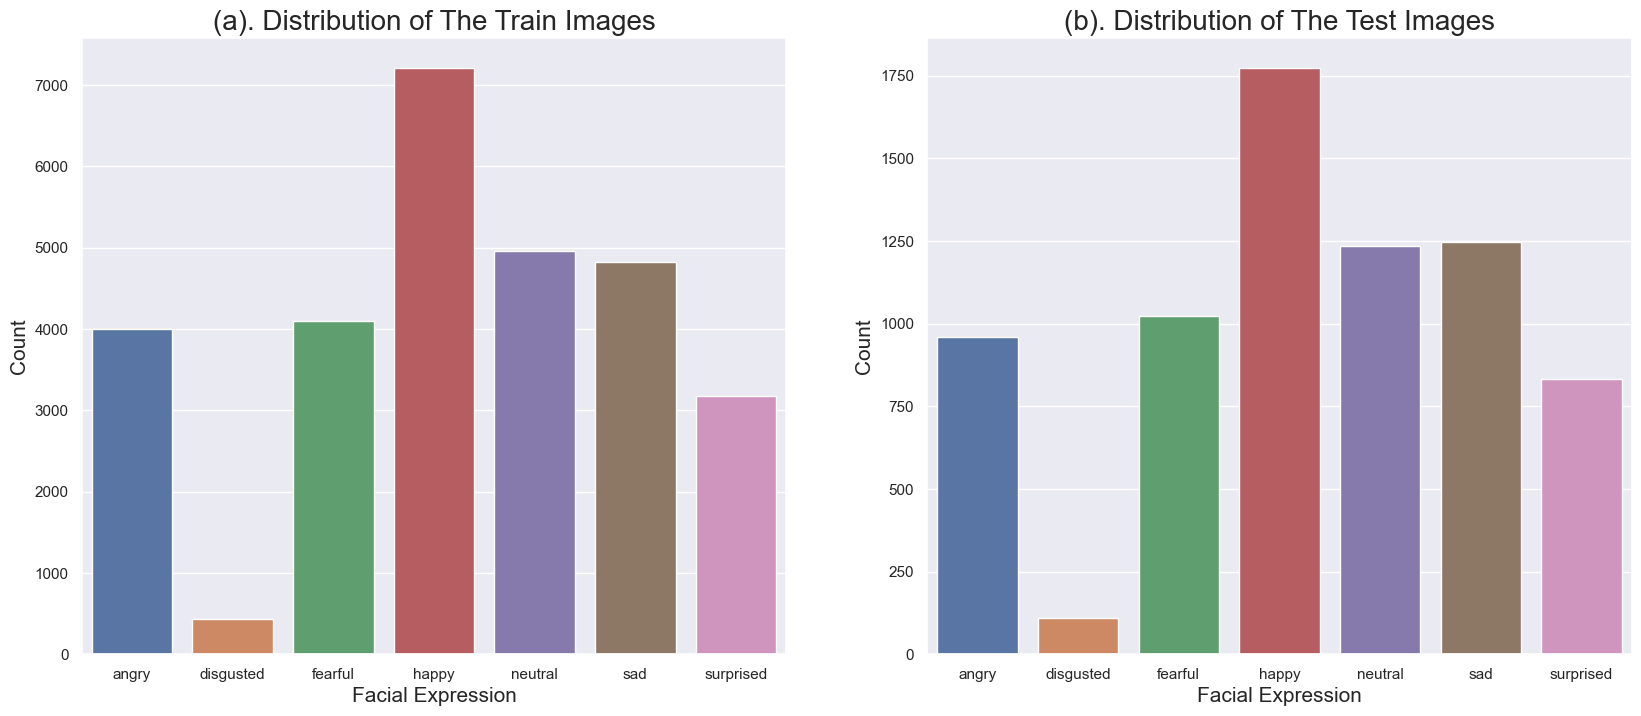

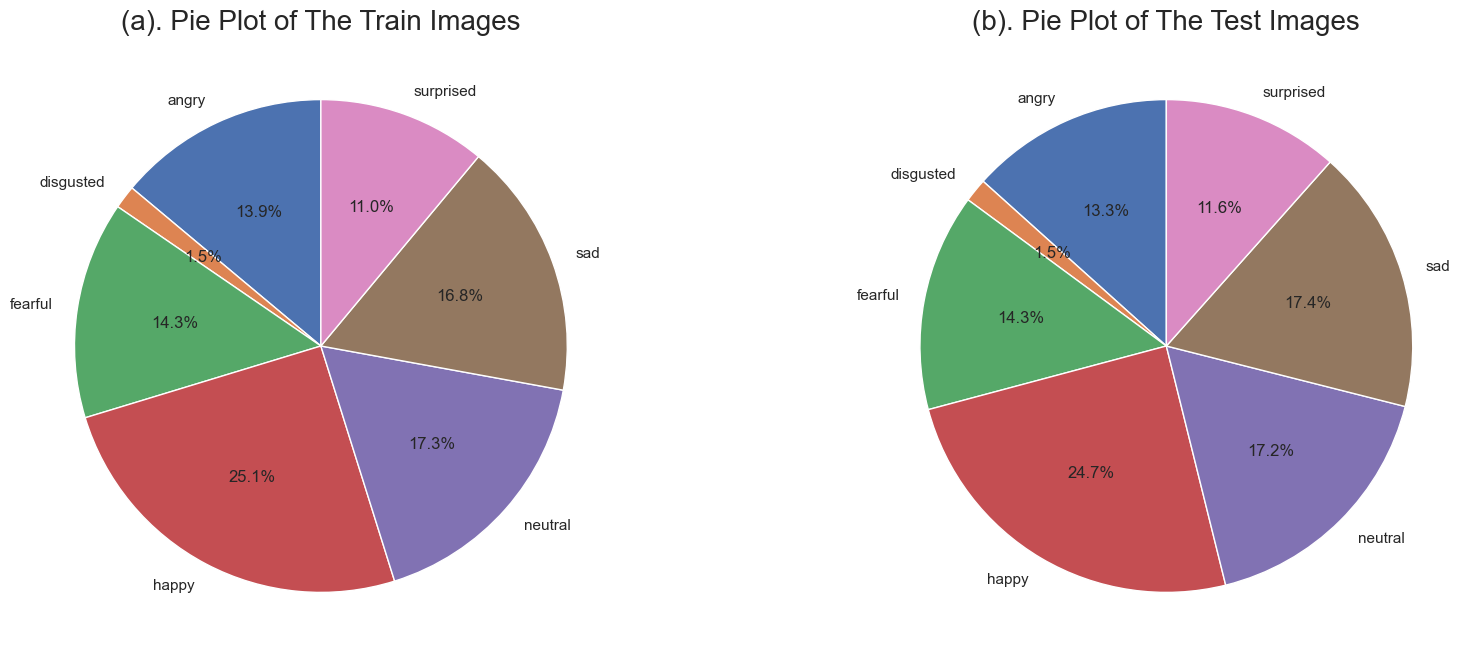

In [63]:
df_train = pds.DataFrame(list(class_sample("train")[2].items()), columns=['Emotion', 'Count'])
df_train.index.name = 'Emotion'
df_test = pds.DataFrame(list(class_sample("test")[2].items()), columns=['Emotion', 'Count'])
df_test.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_train, orient='v')
# set labels and title
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(a). Distribution of The Train Images", fontsize=20)
# plt.legend( df_train.Emotion, loc='upper left')
# set x-axis tick labels
# axis.set_xticks(range(len(df_train.Emotion)), df_train.Emotion)
# axis.yaxis.set_major_locator(ticker.MultipleLocator(2.5))

plt.subplot(1, 2, 2)
sns.barplot(x='Emotion', y='Count', data=df_test, orient='v')
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(b). Distribution of The Test Images", fontsize=20)
plt.show()

print('\n\n')

x_train = npy.array([ len(os.listdir(TRAIN_PATH+'/'+class_name+'/')) for class_name in classes])
x_test = npy.array([ len(os.listdir(TEST_PATH+'/'+class_name+'/')) for class_name in classes])
label = classes
  
# plot a Pie plot with vertical orientation
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.pie(x_train, labels=label, autopct='%1.1f%%', startangle=90)
ax.set_title('(a). Pie Plot of The Train Images', fontsize=20)

ay = plt.subplot(1, 2, 2)
plt.pie(x_test, labels=label, autopct='%1.1f%%', startangle=90)
ay.set_title('(b). Pie Plot of The Test Images', fontsize=20)
plt.show()



<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "data-preprocessing"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Data Preprocessing
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#data-preprocessing">¶</a>
    </h1>
</div>

In [16]:
#Definnig a function to do so 
def grayscale_RGB_and_upsizing(image,size=[224,224]):
    # image = tf.image.grayscale_to_rgb(tf.convert_to_tensor(image))
    image = tf.image.resize(tf.convert_to_tensor(image), size)
    return image

### Data Augmentation

In [ ]:
import os
from PIL import Image

train_dir = 'train'
oversampled_dir = 'oversampled_train'
target_length = 7215

if not os.path.exists(oversampled_dir):
    os.mkdir(oversampled_dir)

for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        for i in range(num_duplicates):
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{i}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

        if remainder != 0:
            for image_file in os.listdir(subfolder_path)[:remainder]:
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{num_duplicates}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)


In [91]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to the original and oversampled dataset
original_dir = TRAIN_PATH
oversampled_dir = OVERSAMPLED_TRAIN_PATH

# Define the classes and their corresponding target number of samples
classes = ['fearful', 'disgusted', 'angry', 'neutral', 'sad', 'surprised', 'happy']
target_samples = {'fearful': 4101, 'disgusted': 4101, 'angry': 4101, 'neutral': 4101, 'sad': 4101, 'surprised': 4101, 'happy': 4101}

# Create the oversampled dataset
for class_name in classes:
    # Create the directory for the current class in the oversampled dataset
    os.makedirs(os.path.join(oversampled_dir, class_name), exist_ok=True)

    # Load the images for the current class from the original dataset
    class_dir = os.path.join(original_dir, class_name)
    image_files = os.listdir(class_dir)

    # Calculate the number of samples to generate for the current class
    num_samples = target_samples[class_name] - len(image_files)

    # Generate the oversampled images for the current class
    if num_samples > 0:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        image_gen = datagen.flow_from_directory(
            class_dir,
            target_size=(224, 224),
            batch_size=1,
            class_mode=None,
            shuffle=False
        )
        for i in range(num_samples):
            image = next(image_gen)[0].astype(npy.uint8)
            image_file = f'{class_name}_{i}.png'
            image_path = os.path.join(oversampled_dir, class_name, image_file)
            plt.imsave(image_path, image)

# Merge the oversampled dataset with the original dataset
merged_dir = 'path/to/merged/dataset'
os.makedirs


Found 0 images belonging to 0 classes.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [35]:
target_size=(48, 48)
# target_size=(224, 224)
batch_size=32

## Train Image Data Generator instance. 
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
trainValidation_data_generator = ImgDataGen(
                                            rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            # preprocessing_function=grayscale_RGB_and_upsizing,
                                            validation_split=0.3    # set the validation split                                
                                            )

# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen(rescale = 1./255,)

# Set a random seed to synchronize the shuffle order across different runs of the generator
# trainValidation_data_generator.set_seed(42)


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "create-train-validation-and-test-generators"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Create Train, Validation, and Test Generators
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#create-train-validation-and-test-generators">¶</a>
    </h1>
</div>

In [36]:
# Successfully mapped the train-images to their classes from the dataframe. Now let's do the same for the test-images. 
# Here, I will only be rescaling. No other transformations are applies, to preserve originality of the images.


## Mapping images to their classes.
print('Train Set Generated - ',end=' ') 
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            shuffle=True, 
                                                            subset='training' # set as training data
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ') 
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            shuffle=False, 
                                                            subset='validation' # set as validation data
                                                        )
test_samples=class_sample('test')[0]
test_batch_size=batch_size
test_steps=int(test_samples/test_batch_size)

## Mapping images to their classes.
print('Test Set Generated - ',end=' ') 
test_generator = test_data_generator.flow_from_directory(
                                        directory=TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        shuffle=False, 
                                        batch_size=test_batch_size
                                        )

Train Set Generated -  Found 20099 images belonging to 7 classes.
Validation Set Generated -  Found 8610 images belonging to 7 classes.
Test Set Generated -  Found 7178 images belonging to 7 classes.


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "more-on-data-analysis"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">More on Data Analysis
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#more-on-data-analysis">¶</a>
    </h1>
</div>

In [37]:
# From the generator we can get information we will need later
classes=os.listdir(TRAIN_PATH+'/')
class_dictionary = train_generator.class_indices
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())
class_count = len(class_keys)

print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)
test_images, test_labels = next(test_generator)

print(f'\nThere are 7 classes: {classes}')
print(f'The class dictionary are: {class_dictionary}')
print('Class count: ', class_count)

print('\nX_train shape: ', train_images.shape)
print('y_train shape: ', train_labels.shape)
print('\nX_test shape: ', test_images.shape)
print('y_test shape: ', test_labels.shape)

print('\ntrain_generator sample: ', train_generator.samples)
print('validation_generator sample: ', validation_generator.samples)
print('test_generator sample: ', test_generator.samples)

print('\ntrain_generator sample: ', train_generator.labels)
print('validation_generator sample: ', validation_generator.labels)
print('test_generator sample: ', test_generator.labels)


test batch size:  32   test steps:  224  number of classes :  7

There are 7 classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
The class dictionary are: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Class count:  7

X_train shape:  (32, 48, 48, 3)
y_train shape:  (32, 7)

X_test shape:  (32, 48, 48, 3)
y_test shape:  (32, 7)

train_generator sample:  20099
validation_generator sample:  8610
test_generator sample:  7178

train_generator sample:  [0 0 0 ... 6 6 6]
validation_generator sample:  [0 0 0 ... 6 6 6]
test_generator sample:  [0 0 0 ... 6 6 6]


In [20]:
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices}
num_images = train_generator.samples

batch_size = train_generator.batch_size
num_batches = len(train_generator)

for i in range(num_batches):
    batch = next(train_generator)
    images, labels = batch
    for j in range(len(labels)):
        label = npy.argmax(labels[j])  # convert one-hot encoding to integer label
        class_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        class_counts[class_name] += 1

print(class_counts)
print(f"Total number of images in train generator: {num_images}")

{'angry': 2797, 'disgusted': 306, 'fearful': 2867, 'happy': 5055, 'neutral': 3473, 'sad': 3382, 'surprised': 2219}
Total number of images in train generator: 20099


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "more-on-data-visualization"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">More on Data Visualization
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#more-on-data-visualization">¶</a>
    </h1>
</div>

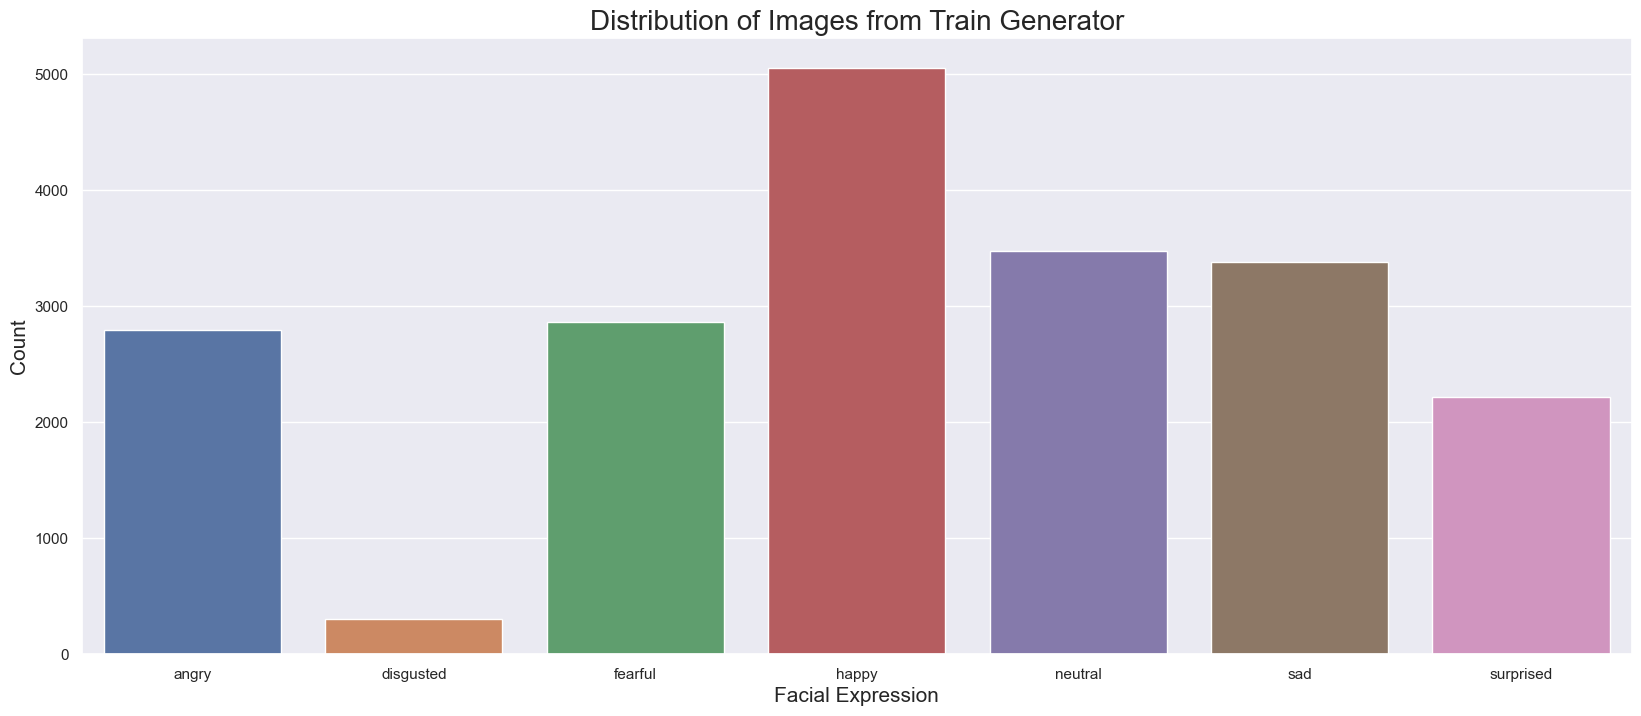

In [64]:
df_train_gen = pds.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
df_train_gen.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
sns.barplot(x='Emotion', y='Count', data=df_train_gen, orient='v')
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Images from Train Generator", fontsize=20)
plt.show()

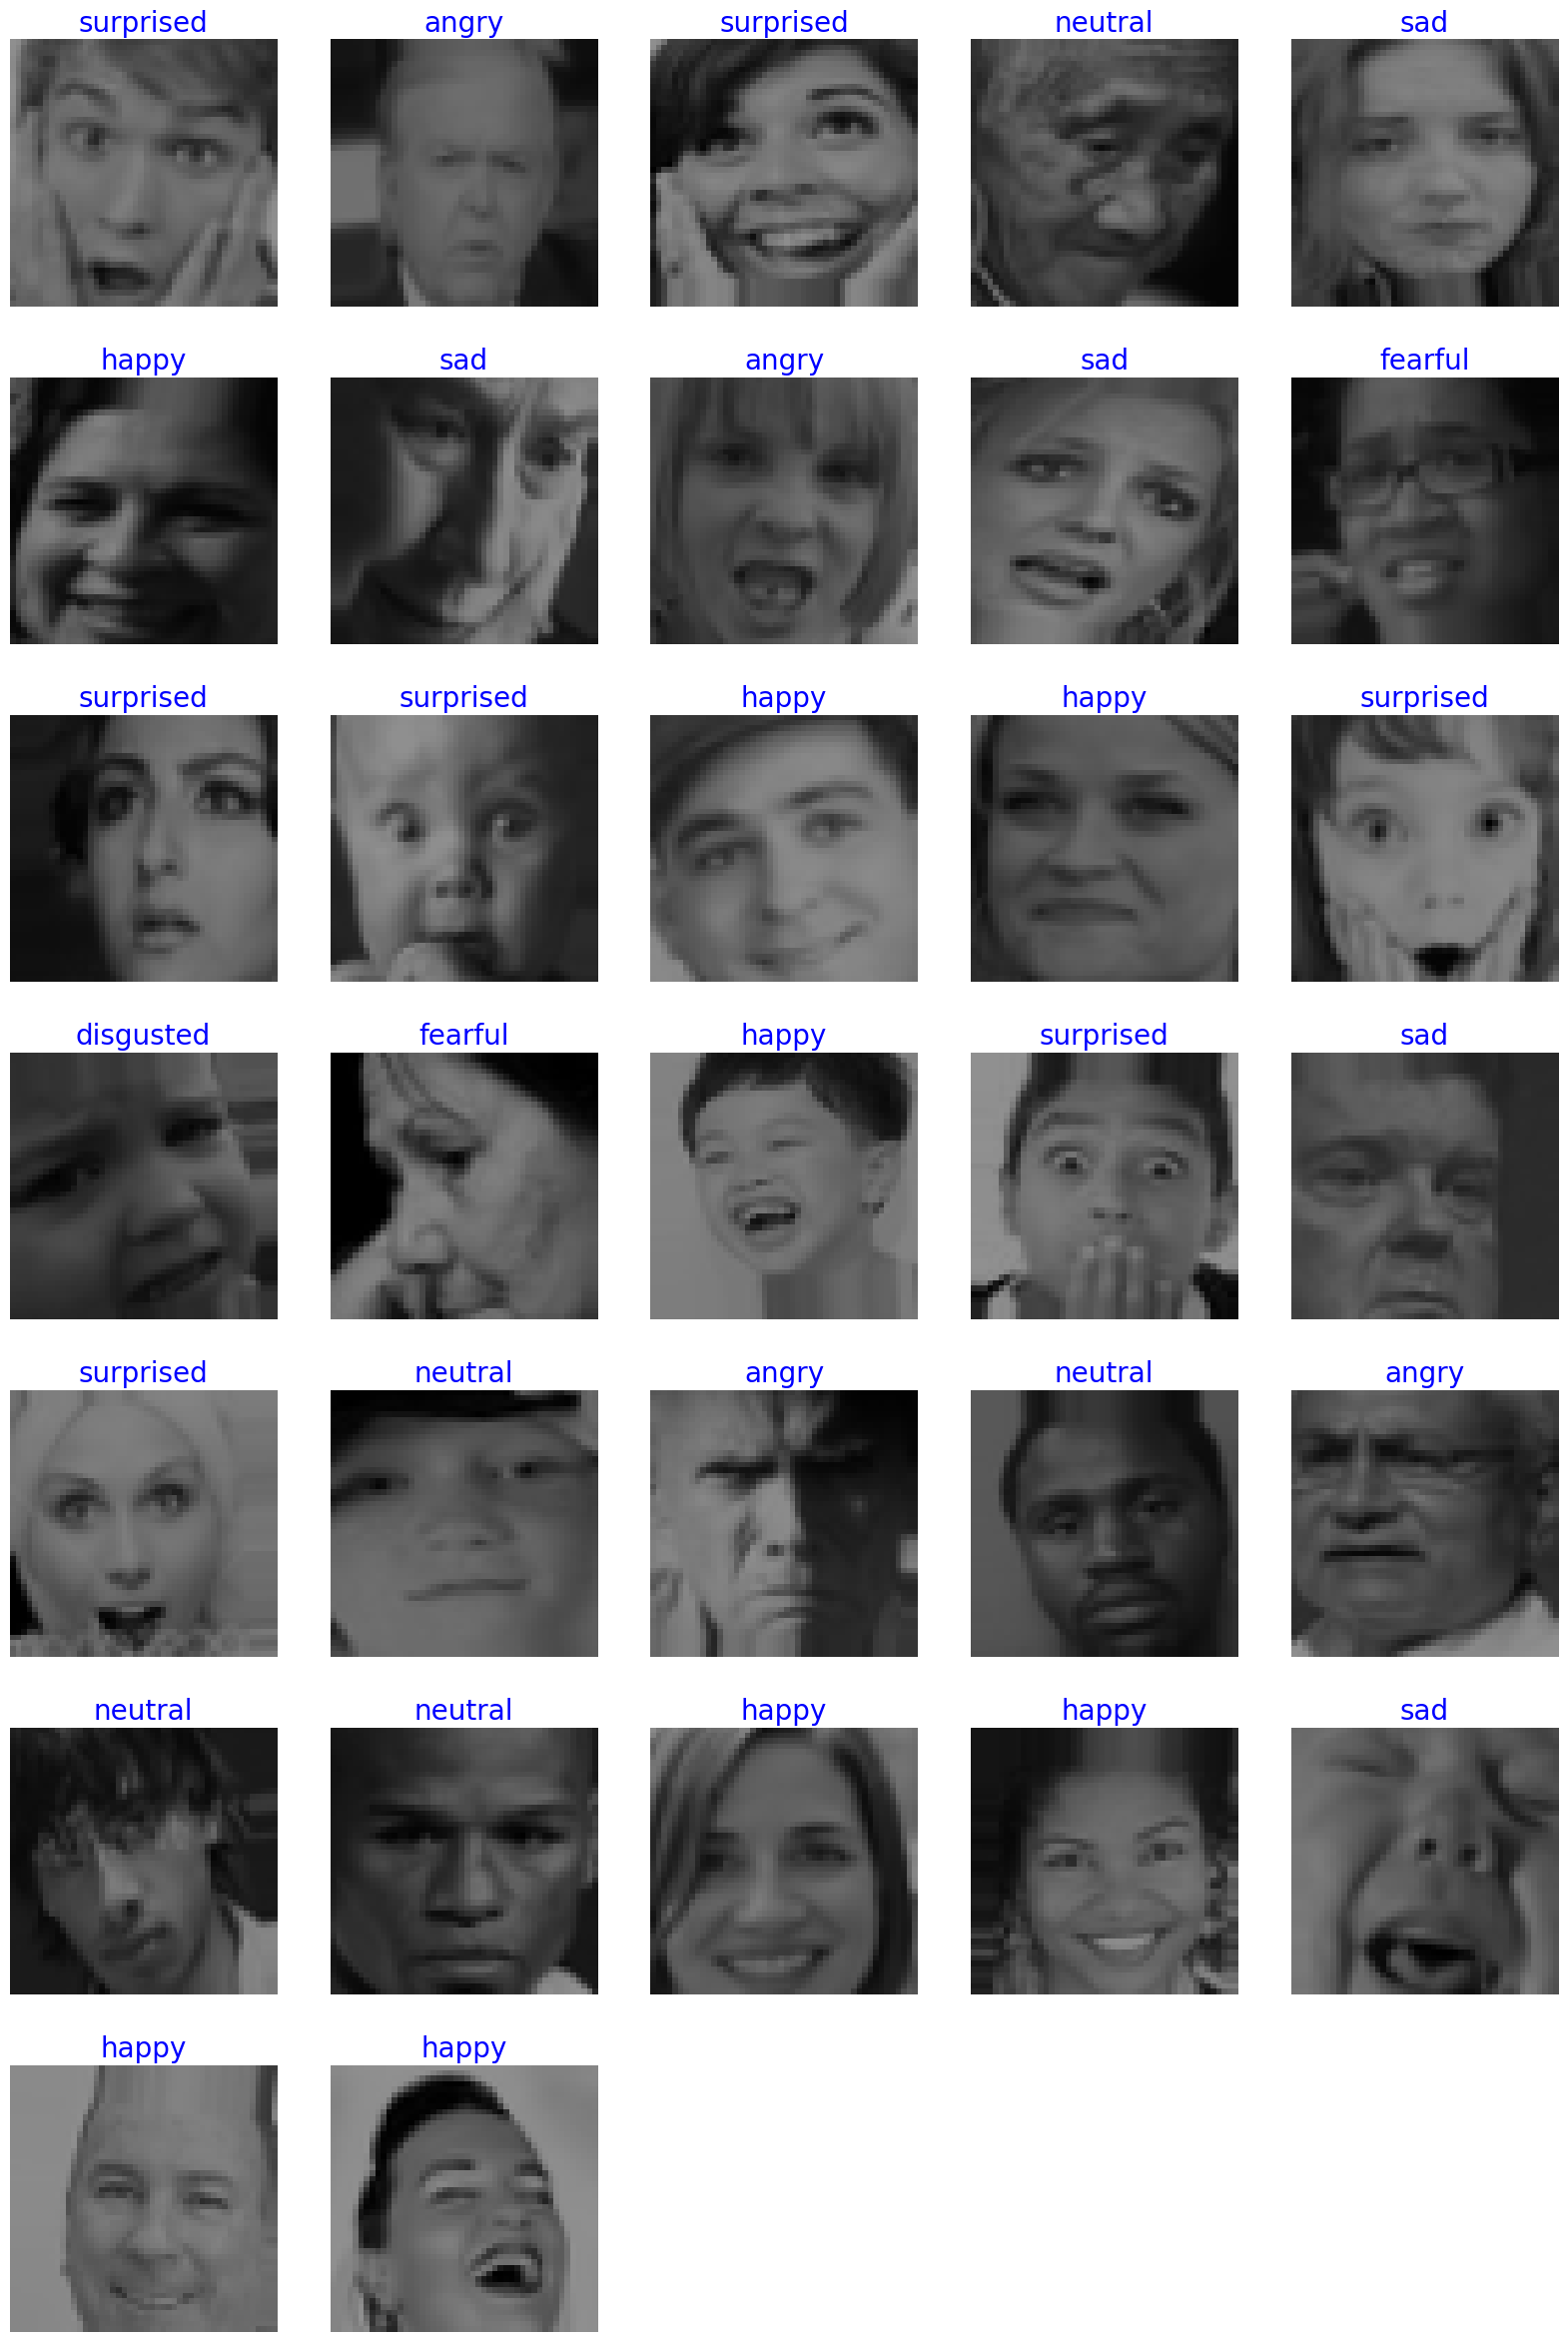

In [41]:
# Get the sample images, labels, and their filenames 
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())
    
    plt.figure(figsize=(20, 30))
    length=len(labels)
    if length<32:  
        r=length
    else:
        r=32
    for i in range(r):        
        plt.subplot(7, 5, i + 1)
        image=images[i] /2
        plt.imshow(image)
        index=npy.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(
                    label=f"{class_name}", # \n{filename} ", 
                    color='blue', 
                    fontsize=20
                    )
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator)

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-development"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Development
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#model-development">¶</a>
    </h1>
</div>

In [23]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import layers, optimizers, metrics, regularizers, models
from tensorflow.keras.optimizers import Adam, Adamax
# from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy


In [42]:
# define the image shape for the input layer
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=60
ask_epoch=10


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-building-and-compiling"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Building and Compiling
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#model-building-and-compiling">¶</a>
    </h1>
</div>

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Model
model_name='EfficientNetB4'
base_model=tf.keras.applications.efficientnet.EfficientNetB4(
                                                            include_top=False, 
                                                            weights="imagenet",
                                                            input_shape=input_shape, 
                                                            pooling='max'
                                                            ) 

# Load the NASNetLarge model
# model_name='NASNetLarge'
# base_model = NASNetLarge(
#                         weights='imagenet', 
#                         include_top=False,
#                         input_shape=img_shape,
#                         pooling='max'
#                         )

# Let's make our base_model trainable to get better results
base_model.trainable=True
x=base_model.output

x=BatchNormalization(
                    axis=-1, 
                    momentum=0.99, 
                    epsilon=0.001,
                    name='batch_norm_x' 
                    )(x)
x = Dense(
          64, 
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu',
          name='dense_x'
          )(x)

x=Dropout(
          rate=.4, 
        #   seed=123,
          name='dropout_x'
          )(x) 
      
output=Dense(
            class_count, 
            activation='softmax',
            name='dense_output'
            )(x)
cnn_model=Model(inputs=base_model.input, outputs=output, name=model_name)
learning_rate=.001 # start with this learning rate
cnn_model.compile(
                  Adamax(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

# View the model summary
cnn_model.summary()

Model: "EfficientNetB4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_6 (Rescaling)        (None, 48, 48, 3)    0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 48, 48, 3)   7           ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 48, 48, 3)    0           ['normalization_3[0]

In [53]:
# Plot the Model Diagram
set_config(display="diagram")
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, to_file=model_arch, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "create-a-custom-keras-callback-to-continue-or-halt-training"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;"> Create a Custom Keras Callback to Continue or Halt Training
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##create-a-custom-keras-callback-to-continue-or-halt-training">¶</a>
    </h1>
</div>

In [50]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.subask_epoch = int(ask_epoch/2)
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, its seems that you want to train for a total of', self.ask_epoch,'\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                        ans=input()
                        
                        if ans == 'Y' or ans =='y':
                            self.epochs = self.ask_epoch
                        else:
                             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        
ask=ASK(cnn_model, epochs,  ask_epoch)

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "checkpoint-callback"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Checkpoint Callback
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##checkpoint-callback">¶</a>
    </h1>
</div>

### Checkpoint 1: Save Weight Only

Creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch.

As long as two models share the same architecture, the weights between them can be shared. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

In [65]:
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=checkpoint_path(model_name),
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning, 
            early_stop, 
            ask
          ]

### Checkpoint 2: Save Entire Model

In [60]:
# starting the Checkpoint for the model
e_checkpoint_path = "models/fedav_best_model.h5"
checkpoint_dir = os.path.dirname(e_checkpoint_path)

e_check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=e_checkpoint_path,
                                          save_weights_only=True,
                                          # save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

e_reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

e_early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

e_callbacks = [
#             e_check_point,
            e_reduce_learning, 
            e_early_stop, 
            ask
          ]

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-training"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Training
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##model-training">¶</a>
    </h1>
</div>

In [57]:
train_generator.n//train_generator.batch_size

628

In [34]:
validation_generator.n//validation_generator.batch_size

269

In [66]:
model_history=cnn_model.fit(
                  train_generator,  
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=validation_generator,
                #   validation_steps=None, 
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                  # shuffle=True,  
                  )


Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/60
628/628 [==============================] - ETA: 0s - loss: 2.0614 - accuracy: 0.3634
Epoch 1: val_accuracy improved from -inf to 0.28555, saving model to models\fedav_best_model-EfficientNetB4.ckpt
628/628 [==============================] - 441s 702ms/step - loss: 2.0614 - accuracy: 0.3634 - val_loss: 2.0417 - val_accuracy: 0.2855 - lr: 0.0010
Epoch 2/60
628/628 [==============================] - ETA: 0s - loss: 1.8067 - accuracy: 0.4010
Epoch 2: val_accuracy did not improve from 0.28555
628/628 [==============================] - 471s 748ms/step - loss: 1.8067 - accuracy: 0.4010 - val_loss: 1.9283 - val_accuracy: 0.2753 - lr: 0.0010
Epoch 3/60
628/628 [==============================] - ETA: 0s - loss: 1.6584 - accuracy: 0.4292
Epoch 3: val_accuracy improved from 0.28555 to 0.39336, saving model to models\fedav_best_

## Acuracy and Loss Function Graph

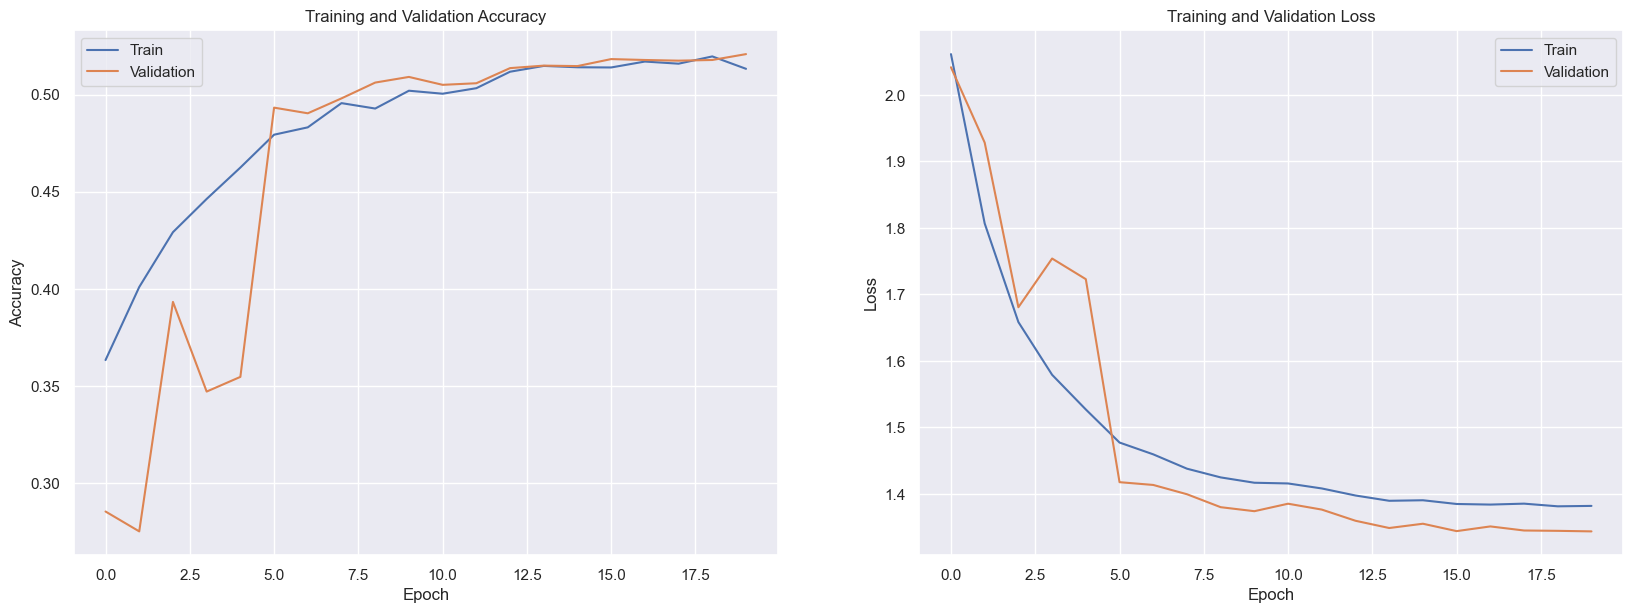

In [67]:
from pylab import rcParams
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)   
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)


# summarize history for accuracy using reLU
sns.set()
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


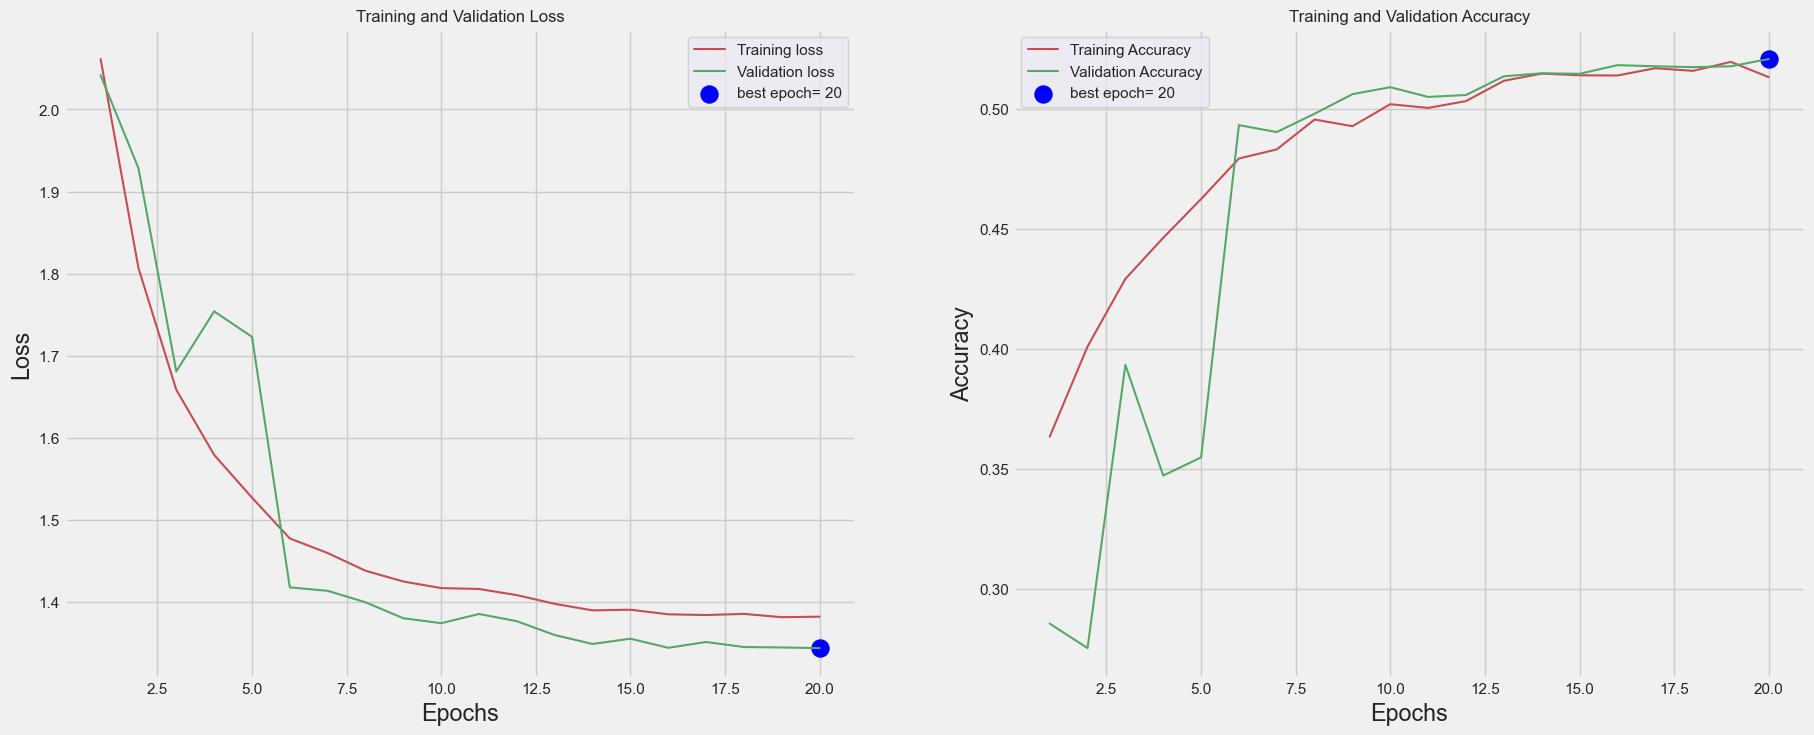

In [68]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
def trainValPlot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=npy.argmin(vloss)   #   this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=npy.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.set()
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
trainValPlot(model_history,0)


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-evaluation"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Evaluation
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##model-evaluation">¶</a>
    </h1>
</div>

In [69]:
# Rebuild a fresh, untrained model and evaluate it on the test set. 
# An untrained model will perform at chance levels (~10% accuracy)
# Create a basic model instance
model = cnn_model

# Evaluate the model
loss, acc = model.evaluate(train_generator, verbose=2)

629/629 - 53s - loss: 1.3008 - accuracy: 0.5459 - 53s/epoch - 84ms/step


In [70]:
# Rebuild a fresh, untrained model and evaluate it on the test set. 
# An untrained model will perform at chance levels (~10% accuracy)
# Create a basic model instance
model = cnn_model

# Evaluate the model
loss, acc = model.evaluate(validation_generator, verbose=2)

270/270 - 24s - loss: 1.3497 - accuracy: 0.5175 - 24s/epoch - 88ms/step


Load the weights from the saved checkpoint and evaluate

In [72]:
# Loads the weights
cnn_model.load_weights(checkpoint_path(model_name=model_name))

# Re-evaluate the model
loss, acc = cnn_model.evaluate(validation_generator, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

270/270 - 23s - loss: 1.3473 - accuracy: 0.5186 - 23s/epoch - 84ms/step
Restored model, validation accuracy: 51.86%


In [74]:
# Loads the weights
cnn_model.load_weights(checkpoint_path(model_name))

# Re-evaluate the model
loss, acc = cnn_model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

1/1 - 0s - loss: 1.5094 - accuracy: 0.4688 - 313ms/epoch - 313ms/step
Restored model, accuracy: 46.88%


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "prediction-on-test-images"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Prediction on Test Images
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##prediction-on-test-images">¶</a>
    </h1>
</div>

225/225 [==============================] - 24s 86ms/step
total prediction: 7178

3385 out of 7178 tested images could not be detected properly given an accuracy of  52.84



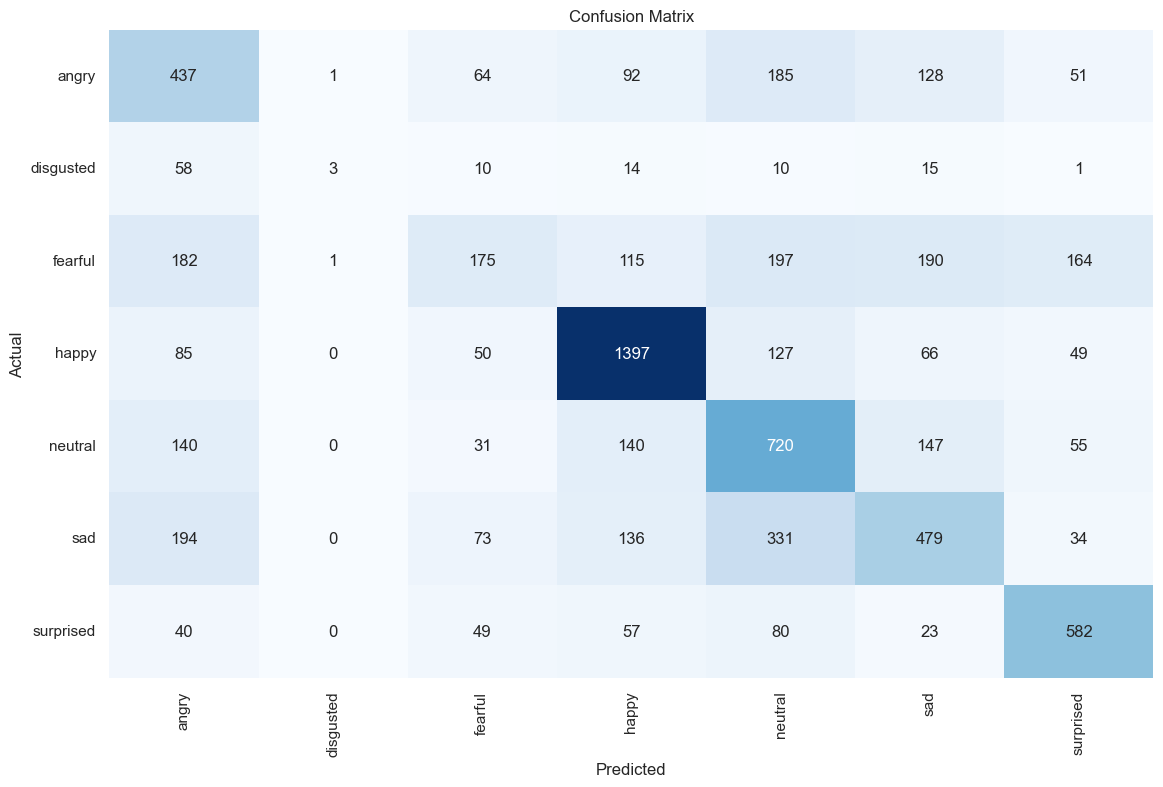

Classification Report:
----------------------
               precision    recall  f1-score   support

       angry    0.38468   0.45616   0.41738       958
   disgusted    0.60000   0.02703   0.05172       111
     fearful    0.38717   0.17090   0.23713      1024
       happy    0.71604   0.78749   0.75007      1774
     neutral    0.43636   0.58394   0.49948      1233
         sad    0.45706   0.38412   0.41743      1247
   surprised    0.62179   0.70036   0.65874       831

    accuracy                        0.52842      7178
   macro avg    0.51473   0.44428   0.43314      7178
weighted avg    0.51916   0.52842   0.51029      7178



In [75]:
# 
def ModelPredictionOnTestDataset(test_generator):
#     test_steps= test_generator.n//test_generator.batch_size
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0
    
    # predict on the test set
    preds=cnn_model.predict(test_generator, test_steps, verbose=1) 
    
    total_predictions=len(preds)
    print(f'total prediction: {total_predictions}')
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)  
            # labels are integer values       
            true_index=test_generator.labels[i]  
            if pred_index != true_index:       
                # a misclassification has occurred                                     
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly given an accuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(npy.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(npy.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_label, y_pred, target_names=classes, digits= 5) # create classification report
    print("Classification Report:\n----------------------\n", clr)

#     # Plot the confusion matrix
#         ConfusionMatrix(
#                         label_test=ytrue, 
#                         label_prep=ypred, 
#                         class_count=class_count, 
#                         class_keys=class_keys, 
#                         heada=' for Entire Test Set'
#                         )
        
    return wrong_predictions, total_predictions

wrong_predictions, total_predictions = ModelPredictionOnTestDataset(test_generator)

### Print Predicted Images: Unshuffled Test Set

1/1 [==============================] - 7s 7s/step
correct prediction: 0.46875 



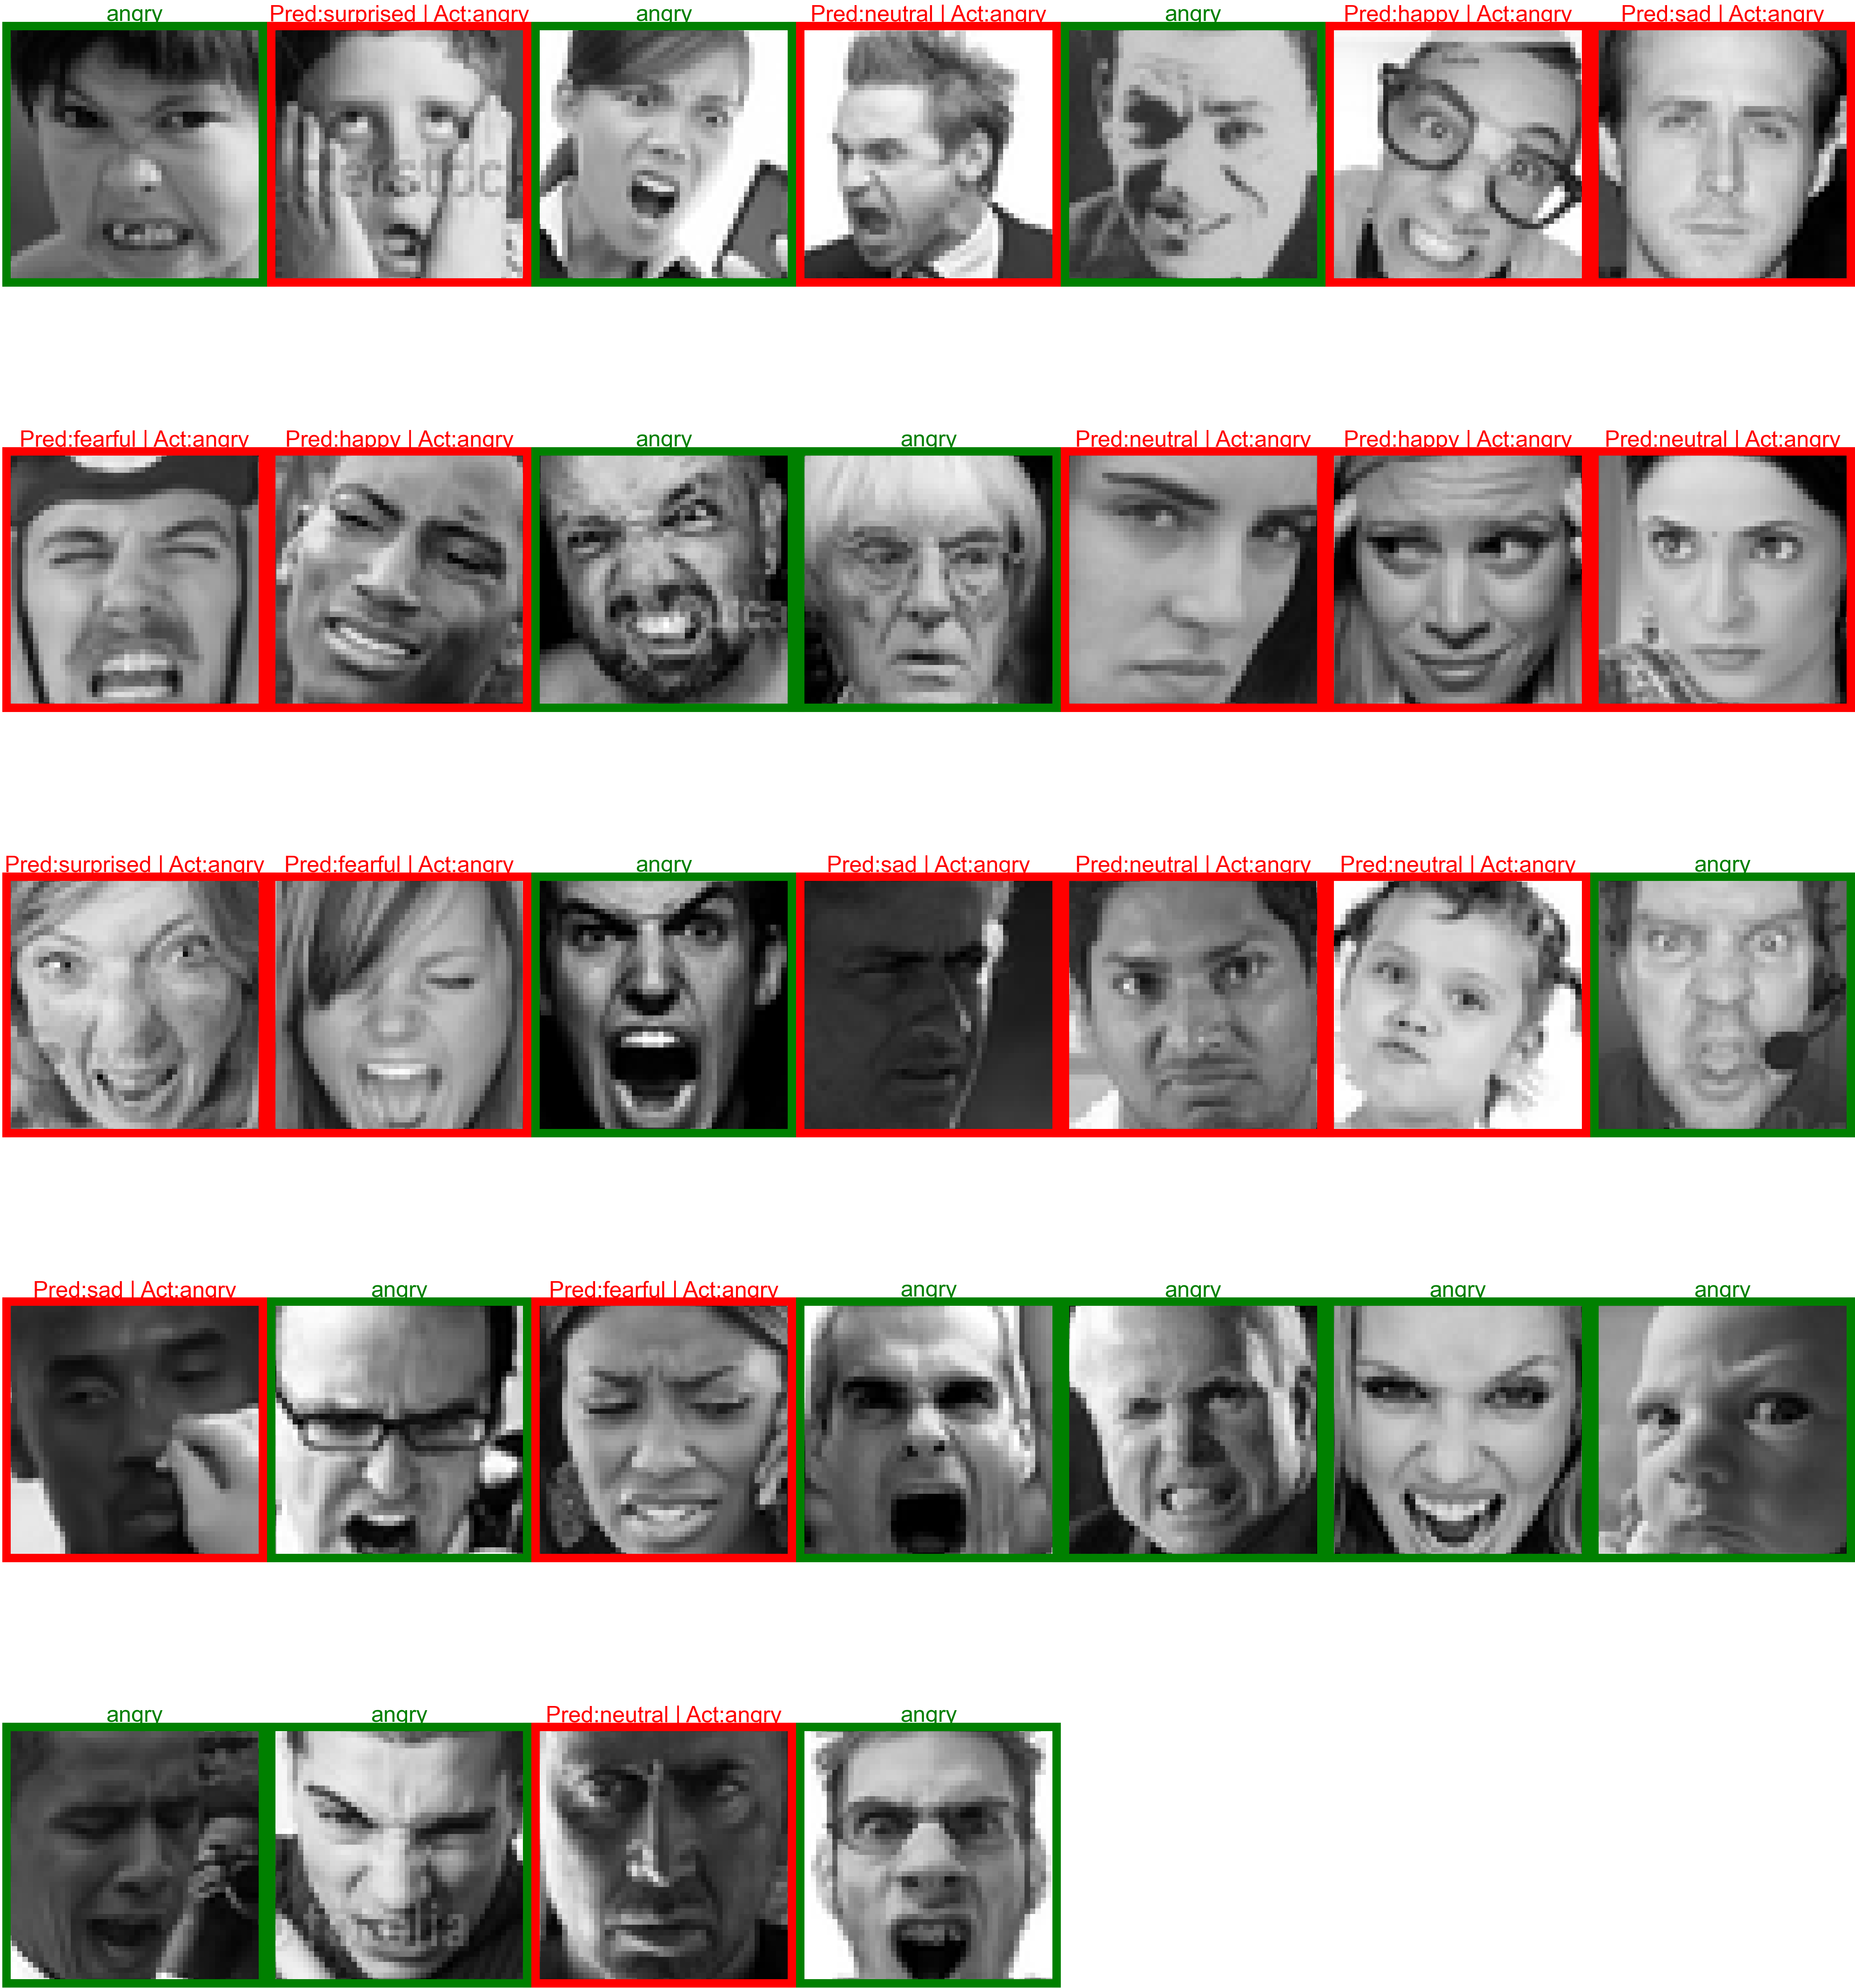

In [76]:
# 
test_images, test_labels = next(test_generator)
preds = cnn_model.predict(test_images)
# One hot conversion
label_prep = npy.argmax(preds, axis = 1)
label_test = npy.argmax(test_labels, axis = 1)
# Reshape
label_prep = label_prep.reshape((-1, 1))
label_test = npy.reshape(label_test, (len(label_test), 1))

print('correct prediction:', npy.sum((label_test == label_prep)*1)/test_batch_size,'\n')


def compare(label_prep, gen=train_generator):
    class_dictionary = gen.class_indices
    for key, value in class_dictionary.items():
        if value == label_prep:
             return key

def dif(label_test, label_prep, gen=train_generator):    
    class_dictionary = gen.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == label_test:
            test = key
        if value == label_prep:
            id = key
    return test, id

#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

fig = plt.figure(figsize=((40, 55)))

# k = 0
for j in range(len(label_prep)):
    ax = plt.subplot(int(test_batch_size/7)+2, 7, j+1)
    px = test_images[j]
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if label_test[j] == label_prep[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(13)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(label_prep[j]),
                    color='green', 
                    fontsize=35
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(13)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(label_test[j], label_prep[j])[1]+" | Act:"+ dif(label_test[j], label_prep[j])[0],
                    color='red', 
                    fontsize=35
                    )
    plt.tight_layout()

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "prediction-on-shuffled-test-images"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Prediction on Shuffled Test Images
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##prediction-on-shuffled-test-images">¶</a>
    </h1>
</div>

In [77]:
## Mapping shuffled images to their classes.
print('Shuffled Test Set Generated - ',end=' ') 
test_generator_shuffled = test_data_generator.flow_from_directory(
                                        TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        shuffle=True, 
                                        batch_size=test_batch_size
                                        )

Shuffled Test Set Generated -  Found 7178 images belonging to 7 classes.


### Batch Size Predictions for Shuffled Test Images

In [78]:
# Function to Plot Confusion Matrix on the Test Set
def ConfusionMatrix(label_test, label_prep, class_count, class_keys, heada = ''):
    from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(label_test, label_prep)
    accuracy = accuracy_score(label_test, label_prep)
    
#     print('accuracy: ', accuracy)
#     class_dictionary = train_generator.class_indices
#     class_keys = list(train_generator.class_indices.keys())
#     class_values = list(train_generator.class_indices.values())
#     class_count = len(class_keys)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(npy.arange(class_count)+.5, class_keys, rotation=90)
    plt.yticks(npy.arange(class_count)+.5, class_keys, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix"+heada)
    plt.show() 
    clr = classification_report(
                                label_test, 
                                label_prep, 
                                target_names=classes, 
                                digits= 4
                                ) # create classification report
    print(f"Classification Report {heada}:\n---------------------------------------------\n", clr)

    print('accuracy: ', accuracy)


In [79]:
def ViewPredictionAndTestLabels(model, test_generator, batch_size):
    test_images, test_labels = next(test_generator)
    preds = model.predict(test_images)
    label_prep = npy.argmax(preds, axis = 1)
    label_test = npy.argmax(test_labels, axis = 1)
    correct_prediction = npy.sum((label_test == label_prep)*1)/batch_size
    print(label_prep)
    print(label_test)
    print('Correct Prediction:', correct_prediction)
    return label_test, label_prep

label_test, label_prep = ViewPredictionAndTestLabels(
                                                    model=cnn_model, 
                                                    test_generator=test_generator_shuffled, 
                                                    batch_size=test_batch_size
                                                    )

1/1 [==============================] - 0s 78ms/step
[0 0 4 4 5 6 2 3 0 4 4 2 5 6 3 3 4 5 4 3 4 5 3 6 3 0 5 5 0 4 5 2]
[0 0 4 4 0 6 6 4 3 4 4 0 1 6 6 3 4 5 0 3 5 5 3 2 3 4 5 5 5 1 5 2]
Correct Prediction: 0.59375


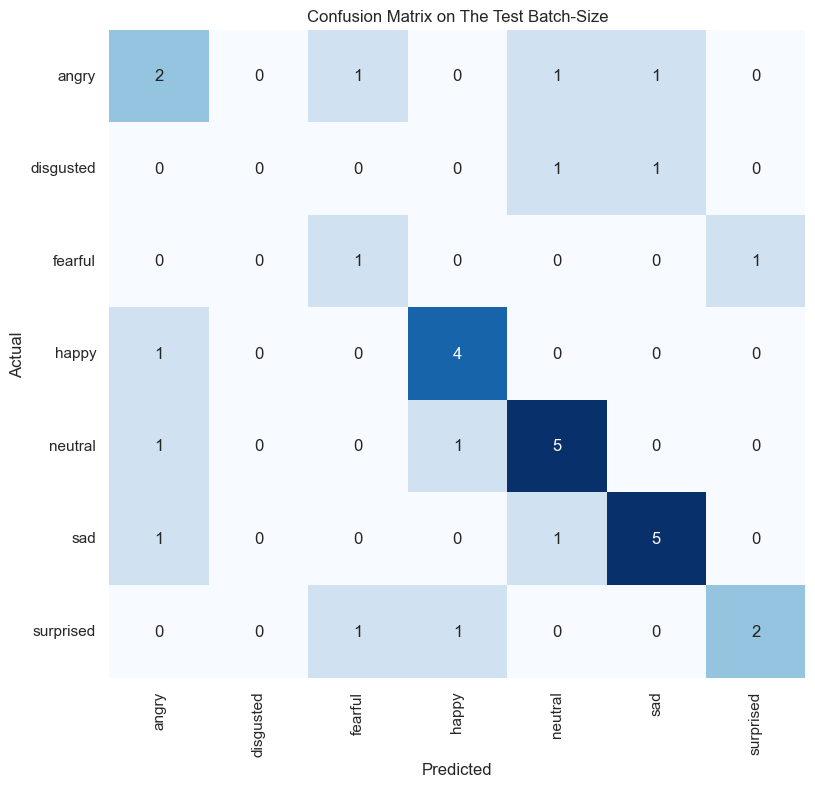

Classification Report  on The Test Batch-Size:
---------------------------------------------
               precision    recall  f1-score   support

       angry     0.4000    0.4000    0.4000         5
   disgusted     0.0000    0.0000    0.0000         2
     fearful     0.3333    0.5000    0.4000         2
       happy     0.6667    0.8000    0.7273         5
     neutral     0.6250    0.7143    0.6667         7
         sad     0.7143    0.7143    0.7143         7
   surprised     0.6667    0.5000    0.5714         4

    accuracy                         0.5938        32
   macro avg     0.4866    0.5184    0.4971        32
weighted avg     0.5638    0.5938    0.5746        32

accuracy:  0.59375


c:\Users\cmanj\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cmanj\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cmanj\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
# Plot Confusion Matrix with Classification Report on the test batch-size data
ConfusionMatrix(
                label_test, 
                label_prep,
                class_count, 
                class_keys,
                heada=' on The Test Batch-Size'
                )

### Print Predicted Images: Shuffled Test Set

1/1 [==============================] - 0s 88ms/step
correct prediction: 0.5625


C:\Users\cmanj\AppData\Local\Temp\ipykernel_8444\3623819581.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(int(test_batch_size/7)+1, 7, j+1)


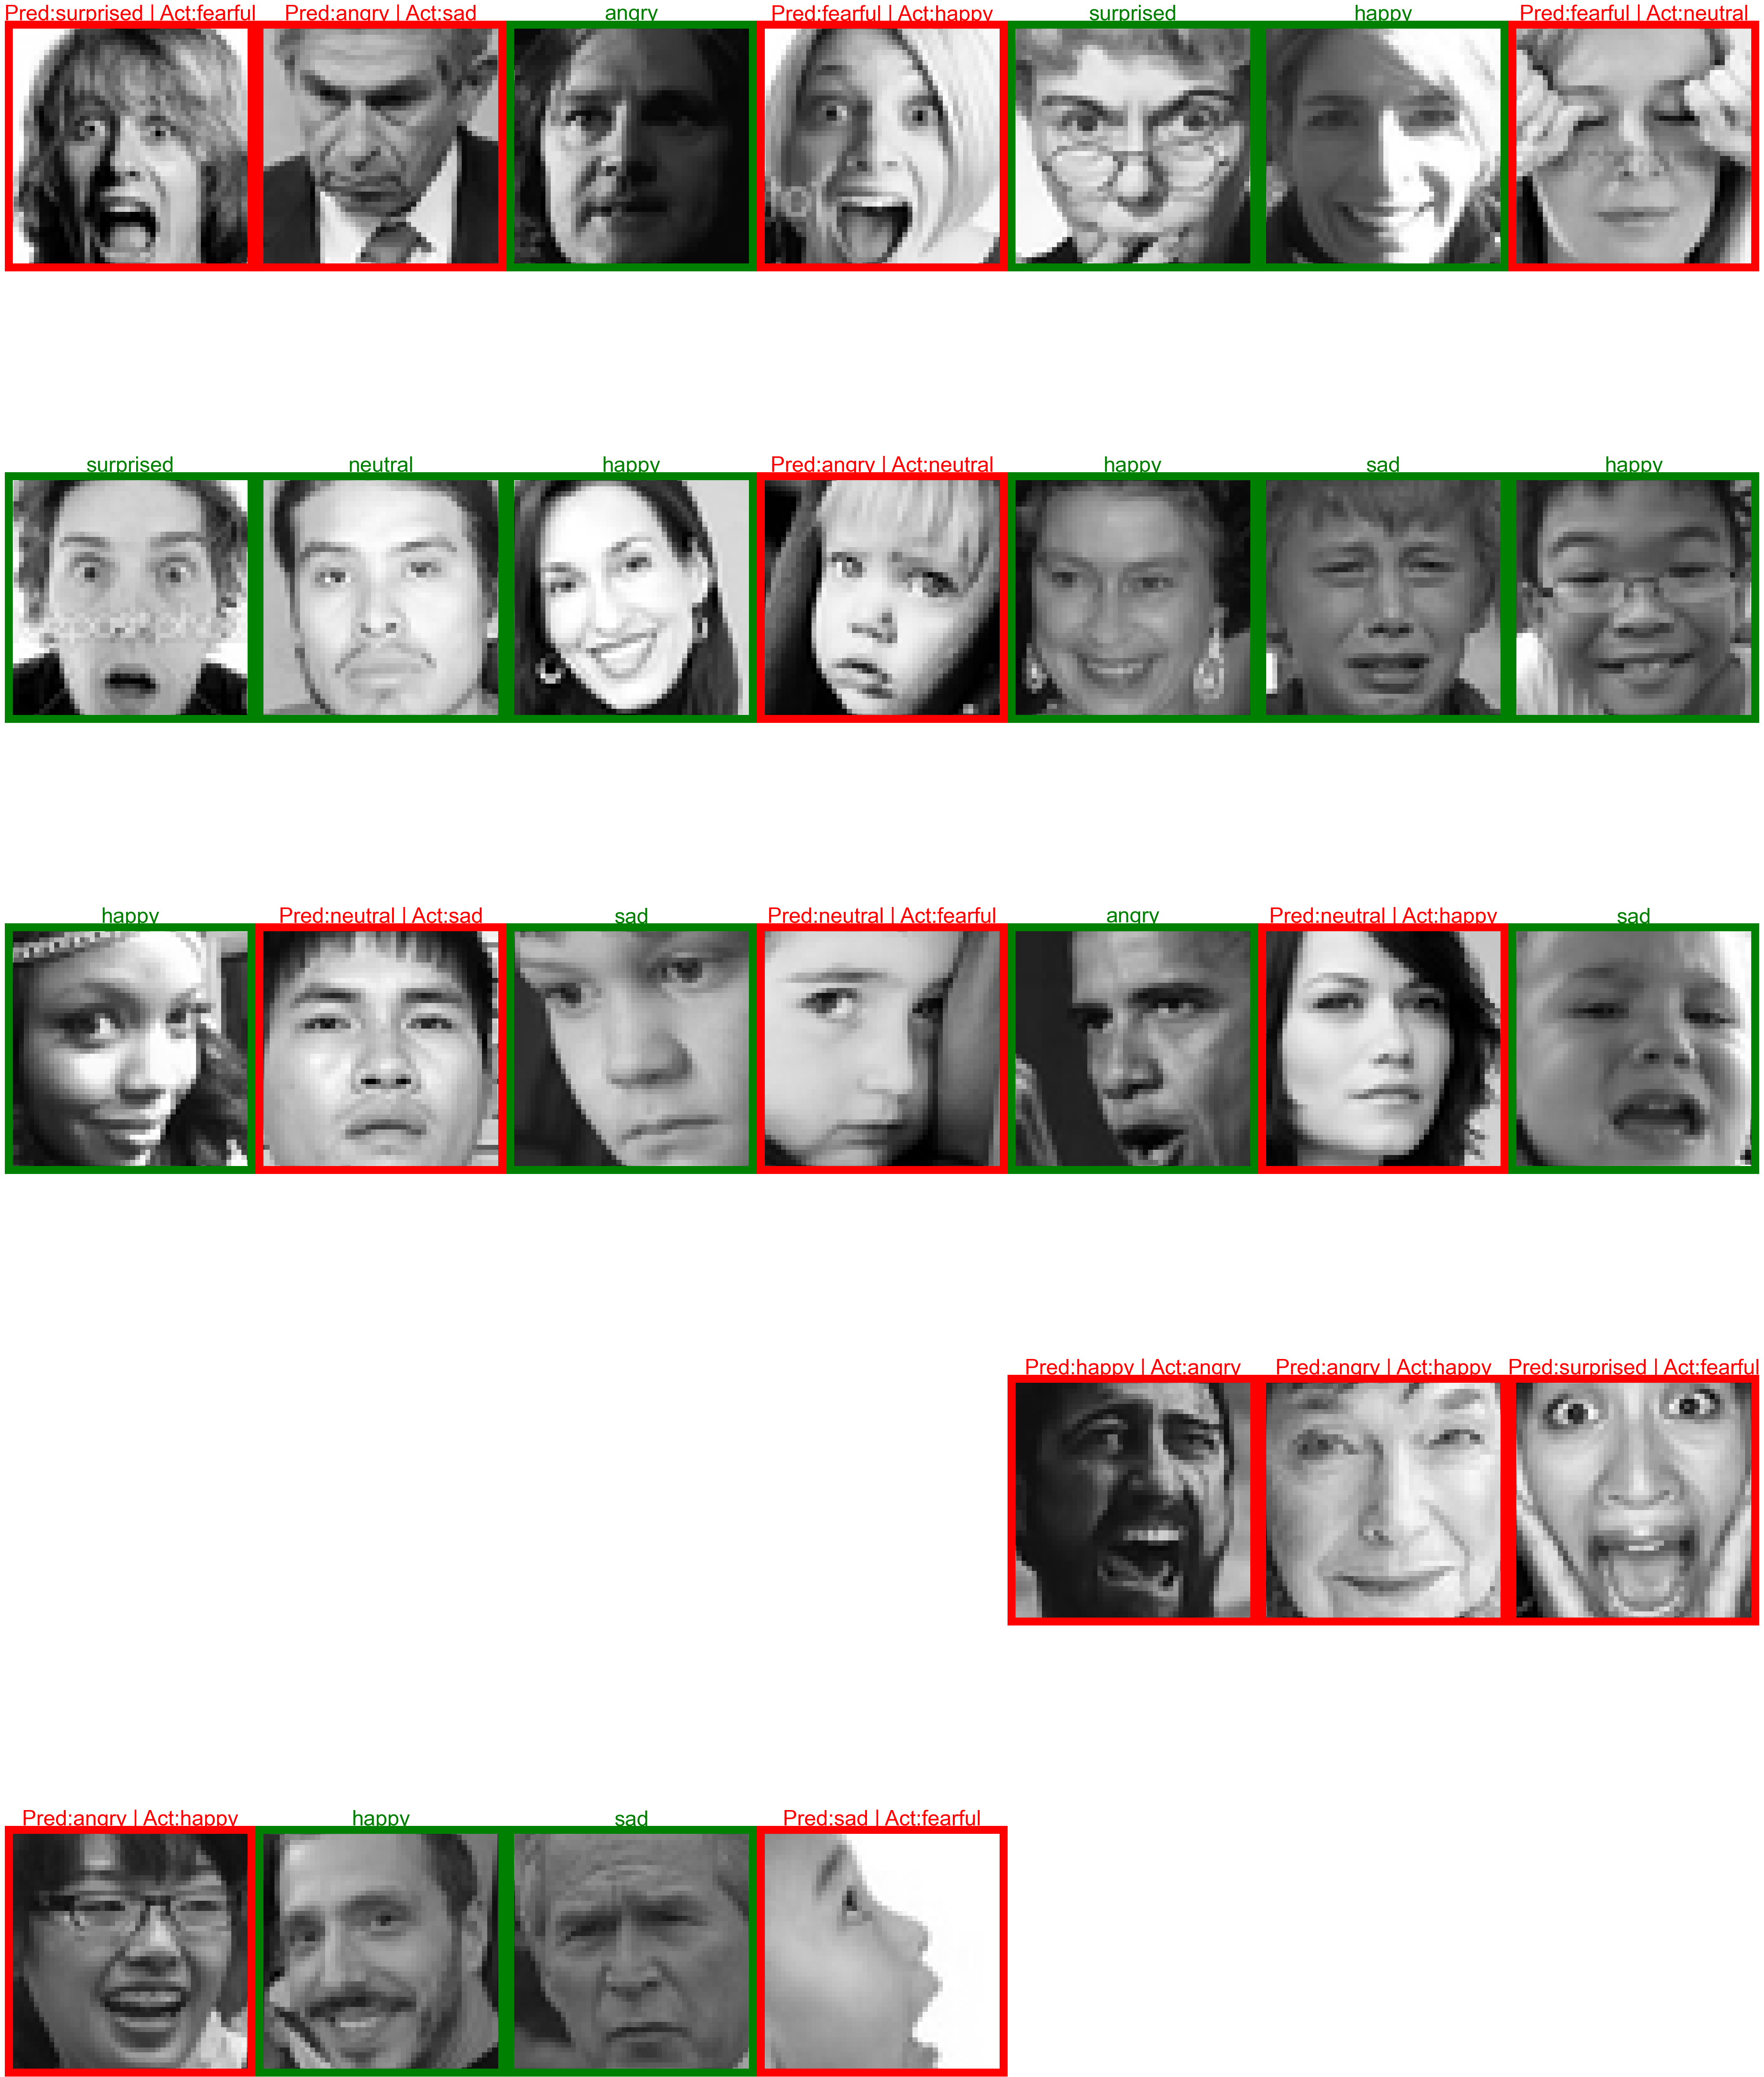

In [87]:
#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection


test_images, test_labels = next(test_generator_shuffled)
preds = cnn_model.predict(test_images)
# print(preds)
idx = npy.argmax(preds, axis = 1)
# test_labels = test_labels.astype(int)
test_labels = npy.argmax(test_labels, axis = 1)
idx = idx.reshape((-1, 1))
test_labels = npy.reshape(test_labels, (len(test_labels), 1))
# print()
print('correct prediction:', npy.sum((test_labels == idx)*1)/test_batch_size)


def compare(idx, train_generator):
    class_dictionary = train_generator.class_indices
    for key, value in class_dictionary.items():
        if value == idx:
             return key

def dif(test_labels, idx, train_generator):    
    class_dictionary = train_generator.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == test_labels:
            test = key
        if value == idx:
            id = key
    return test, id


#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

fig = plt.figure(figsize=((40, 55)))

# k = 0
for j in range(len(idx)):
    ax = plt.subplot(int(test_batch_size/7)+1, 7, j+1)
    px = test_images[j]
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
#     print(idx[j])
#     print(test_labels[j])
    if test_labels[j] == idx[j]:
#     if  class_dictionary[test_labels[j]] == class_dictionary[idx[j]]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(13)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(idx[j], train_generator),
                    color='green', 
                    fontsize=35
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(13)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(test_labels[j], idx[j], train_generator)[1]+" | Act:"+ dif(test_labels[j], idx[j], train_generator)[0],
                    color='red', 
                    fontsize=35
                    )
    plt.tight_layout()

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              ">
    <blockquote id = "prediction-on-shuffled-test-images"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 25px;
                 font-family: Cambria;
                 font-weight: bold;">References
    <ul style ="font-family: Cambria;
                 color: #256d7c;
                 font-size: 15px;
                 font-family: Cambria;
                 font-weight: regular;">
        <li>lerum epsum</li>
        <li>lerum epsum</li>
        <li>lerum epsum</li>
        <li>lerum epsum</li>
    </ul>
   </blockquote>

 </div>